![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Proyecto: Clasificación de imágenes con CNN y Aprendizaje por Transferencia (CIFAR-10)

Este notebook implementa:

1. **CNN desde cero** para CIFAR-10.
2. **Aprendizaje por transferencia** con un modelo preentrenado (ImageNet).
3. **Evaluación y comparación** mediante *accuracy*, *precision*, *recall*, *F1-score* y *matriz de confusión*.

> Dataset: CIFAR-10 (60.000 imágenes RGB 32×32, 10 clases).  


In [ ]:
# =====================================================================================
#  BLOQUE DE LIMPIEZA - EJECUTAR SIEMPRE PRIMERO PARA EVITAR BUG DE CNN (KERNEL SUCIO)
# =====================================================================================

import gc
import tensorflow as tf
from tensorflow import keras

# 1. Limpiar sesión de Keras
keras.backend.clear_session()

# 2. Resetear grafos de TensorFlow
tf.compat.v1.reset_default_graph()

# 3. Liberar memoria GPU (si tienes)
try:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
except:
    pass

# 4. Forzar recolección de basura
gc.collect()

# 5. NO ELIMINAR EL CACHE!!!

print("Kernel limpiado - listo para entrenar")

Kernel limpiado - listo para entrenar


In [ ]:
# IMPORTACIONES Y CONFIGURACIÓN DE REPRODUCIBILIDAD
# =================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

import os

np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10 # CARGA DEL CONJUNTO DE DATOS CIFAR-10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # CARGA DEL CONJUNTO DE DATOS CIFAR-10

# VALIDACION (recomendado en ANN/RNN/CNN)
# =======================================

x_train_final, x_val, y_train_final, y_val = train_test_split(
     x_train, y_train,
     test_size=0.2,  # 20% para validación de 5000 imagenes
     random_state=1,
     stratify=y_train)

size_Xdata = len(x_train_final)

x_train_final = np.array(x_train_final) # CONVERTIR A ARRAY NUMPY
y_train_final = np.array(y_train_final) # CONVERTIR A ARRAY NUMPYX

x_val = np.array(x_val) # CONVERTIMOS A NUMPY ARRAY
y_val = np.array(y_val) # CONVERTIMOS A NUMPY ARRAY

x_test = np.array(x_test) # CONVERTIMOS A NUMPY ARRAY
y_test = np.array(y_test) # CONVERTIMOS A NUMPY ARRAY

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'] # NOMBRES DE LAS CLASES

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
print(size_Xdata//64)


625


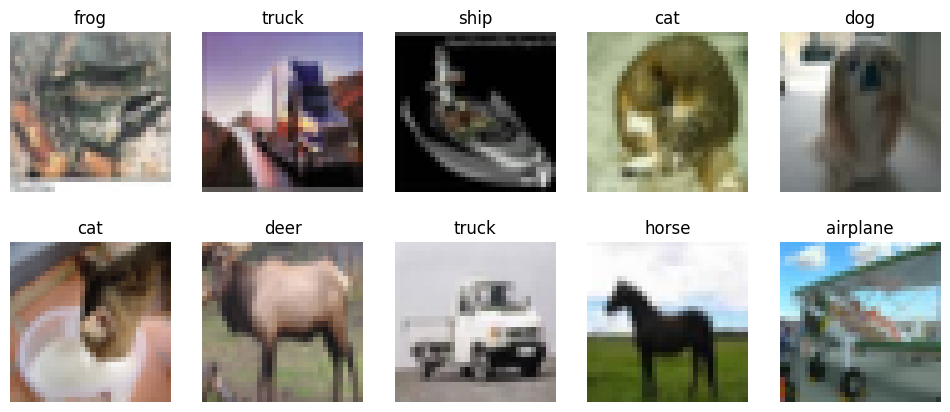

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(12,5)) # CREAMOS SUBPLOTS
axes = axes.flatten() # APLANAMOS PARA ITERAR MÁS FÁCILMENTE

random_list = random.sample(range(size_Xdata), 10) # ELEGIMOS 10 ÍNDICES ALEATORIOS SIN REPETICIÓN

for i,idx in enumerate(random_list):
    axes[i].imshow(x_train_final[idx] / 255.0)
    label = y_train_final[idx].item()
    axes[i].set_title(f'{class_names[(label)]}') # CONVERTIMOS EN INT A Y_TRAIN PARA USARLO COMO ÍNDICE
    axes[i].axis('off')

plt.show()

In [ ]:
# PREPROCESAMIENTO DE DATOS
# ==========================

# Normalización
x_train_final = x_train_final / 255.0    # Normalizo el Xtrain porque entra al fit
x_test = x_test / 255.0
x_val = x_val / 255.0                    # Normalizo el Xval porque entra al fit para VALIDAR

print(f'X_train shape: {x_train_final.shape}')
print(f'X_test shape: {x_test.shape}')
print(f'Y_train shape: {y_train_final.shape}')
print(f'Y_test shape: {y_test.shape}')


X_train shape: (40000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
Y_train shape: (40000, 1)
Y_test shape: (10000, 1)


In [ ]:
# ARQUITECTURA DE MI MODELO

model = Sequential()

model.add(Input(shape=(32, 32, 3)))

model.add(Conv2D(32, (3, 3), activation='relu'))    # PRIMERA CAPA CONVOLUCIONAL
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))    # SEGUNDA CAPA CONVOLUCIONAL
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))   # TERCERA CAPA CONVOLUCIONAL
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())                                # POOLING GLOBAL

model.add(Dense(64, activation='relu'))             # CAPA DENSAMENTE CONECTADA
model.add(Dropout(0.45))

model.add(Dense(10, activation='softmax'))          # CAPA DE SALIDA

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,730 (495.04 KB)

 Trainable params: 126,730 (495.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# AUMENTO DE DATOS

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train_final)

# COMPILACIÓN Y ENTRENAMIENTO
# ===========================

model.compile(
    optimizer=Adam(learning_rate=0.0001),   # Optimizador Adam con lr=0.001
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,       # Más paciencia
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1)

history = model.fit(
     datagen.flow(x_train_final, y_train_final, batch_size=64, seed = 1),    # Entrenamos con los Xtrain finales
     steps_per_epoch= 625,  # size_Xdata // 64,
     epochs=400,
     verbose=1,
     validation_data=(x_val, y_val),  # Validamos con un set exclusivo para validacion
     callbacks=[early_stop])

print("Entrenado!")

Epoch 1/400


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 158ms/step - accuracy: 0.1313 - loss: 2.2703 - val_accuracy: 0.2330 - val_loss: 2.0696
Epoch 2/400
625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 135ms/step - accuracy: 0.2360 - loss: 2.0373 - val_accuracy: 0.3164 - val_loss: 1.9008
Epoch 3/400
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 135ms/step - accuracy: 0.2813 - loss: 1.9234 - val_accuracy: 0.3597 - val_loss: 1.8088
Epoch 4/400
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 134ms/step - accuracy: 0.3053 - loss: 1.8513 - val_accuracy: 0.3833 - val_loss: 1.7333
Epoch 5/400
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 134ms/step - accuracy: 0.3272 - loss: 1.7961 - val_accuracy: 0.4164 - val_loss: 1.6601
Epoch 6/400
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 132ms/step - accuracy: 0.3439 - loss: 1.7571 - val_accuracy: 0.4256 - val_loss: 1.6235
Epoch 7/400
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 132ms/step - accuracy: 0.3670 - loss: 1.6979 - val_accuracy: 0.4321 - val_loss: 1.5894
Epoch 8/400
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.3843 - loss

In [ ]:
# Predecir probabilidades
y_pred_probs = model.predict(x_val, verbose=0)

# Convertir a etiquetas usando argmax
y_pred = np.argmax(y_pred_probs, axis=1)

# Reporte de clasificación
from sklearn.metrics import classification_report
report = classification_report(y_val, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

    airplane       0.84      0.79      0.82      1000
  automobile       0.87      0.92      0.90      1000
        bird       0.72      0.66      0.69      1000
         cat       0.62      0.61      0.62      1000
        deer       0.74      0.80      0.77      1000
         dog       0.73      0.66      0.69      1000
        frog       0.80      0.87      0.84      1000
       horse       0.84      0.81      0.82      1000
        ship       0.84      0.92      0.87      1000
       truck       0.85      0.85      0.85      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



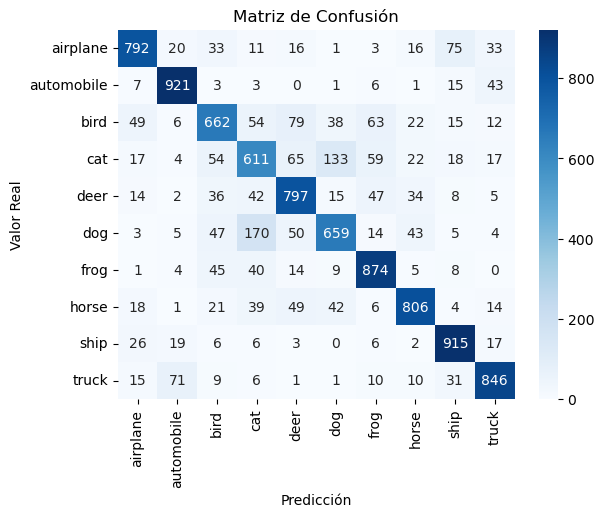

In [ ]:
# =====================
#  Matriz de Confusión
# =====================

y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

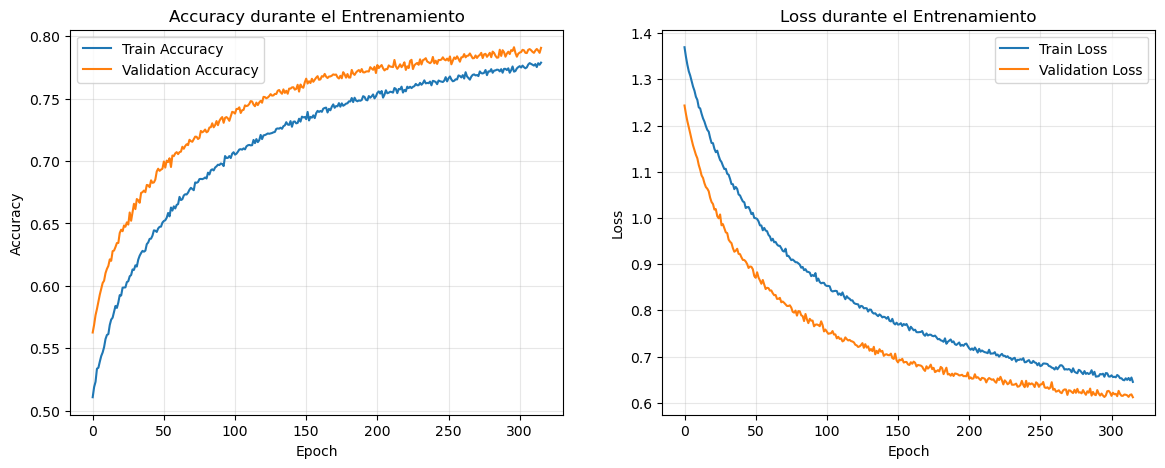

TRAIN:
Loss óptimo: 0.6452
Accuracy óptimo: 77.89%
Loss final: 0.6452
Accuracy final: 77.89%

VALIDATION:
Loss óptimo: 0.6120
Accuracy óptimo: 79.08%
Loss final: 0.6120
Accuracy final: 79.08%


In [ ]:
# VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
# ======================================

# Crear figura con 2 subgráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy durante el Entrenamiento')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss durante el Entrenamiento')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.show()

best_epoch = np.argmin(history.history['val_loss'])
print(f"TRAIN:")
print(f"Loss óptimo: {history.history['loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['accuracy'][-1]*100:.2f}%")
print()
print(f"VALIDATION:")
print(f"Loss óptimo: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['val_accuracy'][-1]*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


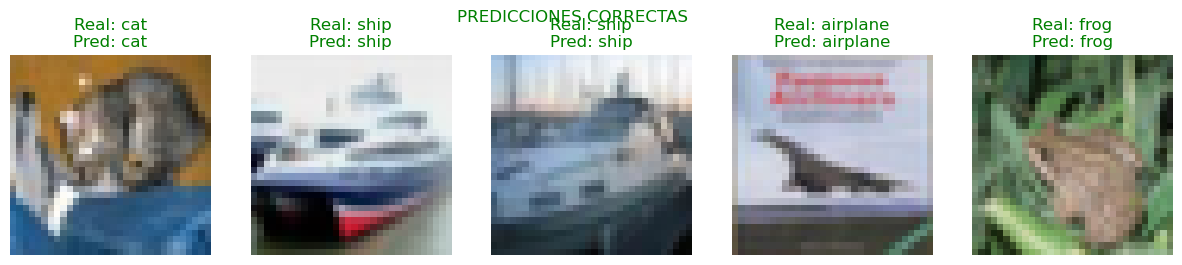

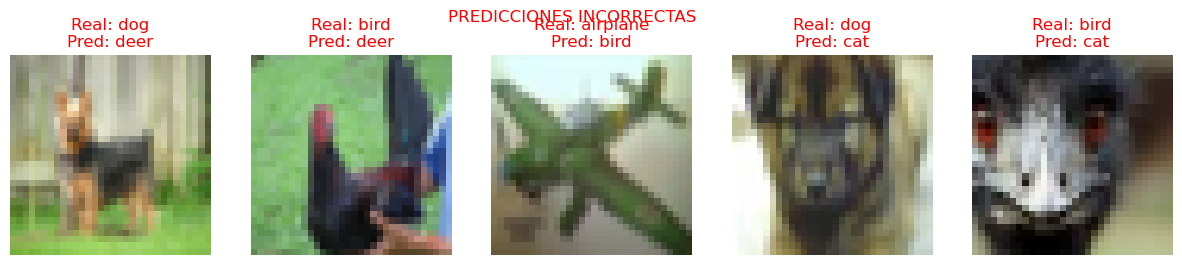

In [ ]:
# Asegúrate de que y_test sea un vector 1D de enteros
y_test_labels = y_test.flatten().astype(int)

# Predicciones
y_pred = np.argmax(model.predict(x_test), axis=1).astype(int)  # enteros puros

# Correctas e incorrectas
correct_indices = np.where(y_pred == y_test_labels)[0]
incorrect_indices = np.where(y_pred != y_test_labels)[0]

# 5 predicciones correctas
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = correct_indices[i]
    axes[i].imshow(x_test[idx])
    axes[i].set_title(f'Real: {class_names[int(y_test_labels[idx])]}\nPred: {class_names[int(y_pred[idx])]}', color='green')
    axes[i].axis('off')
plt.suptitle('PREDICCIONES CORRECTAS', color='green')
plt.show()

# 5 predicciones incorrectas
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    idx = incorrect_indices[i]
    axes[i].imshow(x_test[idx])
    axes[i].set_title(f'Real: {class_names[int(y_test_labels[idx])]}\nPred: {class_names[int(y_pred[idx])]}', color='red')
    axes[i].axis('off')
plt.suptitle('PREDICCIONES INCORRECTAS', color='red')
plt.show()